# Defining single-chain Structure Factor

### How to evaluate:
1) Fourier transform of pair correlation function (466 Lec 4)

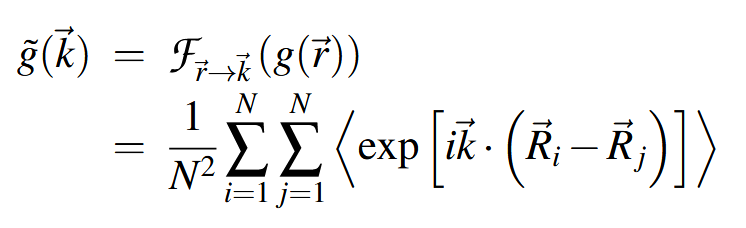


    a) Laplace inversion of wlc Green's function in Fourier-Laplace space (wlcstat doc)
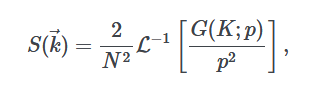
    


2) I_s(q) / I_s(q=0) (466 Lec 7, Rubinstein 2.8.2)
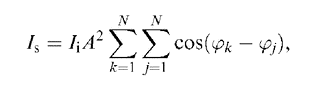
 
### Why it matters:

 "correlating scattering experiments with theoretical models provides insight into the physical behavior in polymeric fluids"
 
 generally, can tell error in [R_ij] -> at small scattering wavevector q, can compare <R_g^2>
 
 Experimentally verify theory polymer behavior in presence of different solvents

Fundamentally, any structure facot is essentially letting you know about how densities correlate
AB structure factor- at some position with vol frac A, what is the probability of vol frac B a certain distance away

#### meaning of single-chain?
Experimental result is a summation of monomer on a chain- makes sense

Analytical result (at small q) averaging over ensemble? single chain != in isolation?

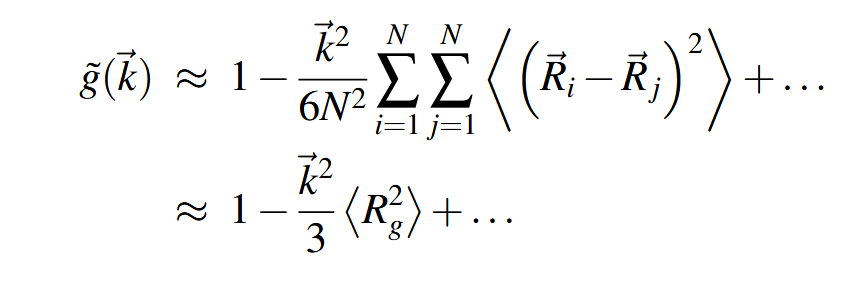



#### How does solvent enviroment impact these results?

structure factor essentially only depends on chain conformation and scattering wavevector


but, for the analytical solution, introducing interactions (bead-bead, bead-solvent) would change polymer conformations


Are these interactions considered in the evaluation of structure factor? (quasi-chemical solution model

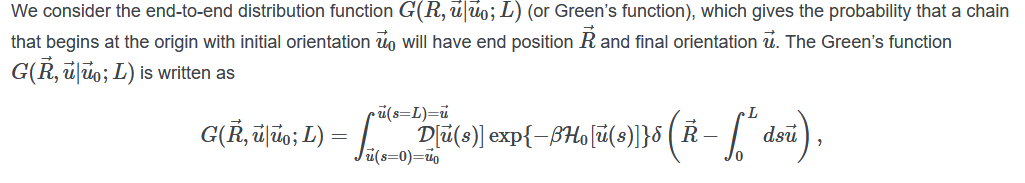

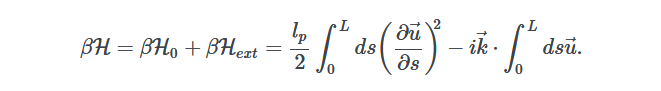

In [1]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import pandas as pd
import wlcave as wlcave #need to path correctly!
import matplotlib.cm as cm
import sys
from wlcstat.wlcstruc import *
import itertools

#for data processing
import os
import operator
import xlrd

In [2]:
import matlab.engine
eng = matlab.engine.start_matlab()

In [4]:
import seaborn as sns

Two appraoches: 

- Fourier transform of pair correlation function
- Ratio of I_scattered(q) / I_scattered(q=0)

# AB melt:

### Simulation data:

##### chi = 0 lambda = 0, N_m = 0.05 (rigid)

In [3]:
# #EDIT PATHS
# # chi_zero_1_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.13.21_ABmelt_fully_reproduced_shorter_range_96hrs_OLD/all_rs/r50v1"
# # chi_zero_2_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_72hrs_OLD/all_rs/r39v1"
# # chi_zero_3_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_160hrs_OLD/all_rs/r92v1"
# # chi_zero_4_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_96hrs_OLD/all_rs/r49v1"
# # chi_zero_5_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_120hrs_OLD/all_rs/r64v1"

# chi_zero_1_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/lam=0_rigid/r50v1"
# chi_zero_2_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/lam=0_rigid/r39v1"
# chi_zero_3_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/lam=0_rigid/r92v1"
# chi_zero_4_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/lam=0_rigid/r49v1"
# chi_zero_5_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/lam=0_rigid/r64v1"

# name_list = ["X", "Y", "Z", "Type"] 
# chi_zero_1_df = pd.read_csv(chi_zero_1_path, names = name_list, delim_whitespace=True)
# chi_zero_2_df = pd.read_csv(chi_zero_2_path, names = name_list, delim_whitespace=True)
# chi_zero_3_df = pd.read_csv(chi_zero_3_path, names = name_list, delim_whitespace=True)
# chi_zero_4_df = pd.read_csv(chi_zero_4_path, names = name_list, delim_whitespace=True)
# chi_zero_5_df = pd.read_csv(chi_zero_5_path, names = name_list, delim_whitespace=True)
# chi_zero_list = [chi_zero_1_df, chi_zero_2_df, chi_zero_3_df, chi_zero_4_df, chi_zero_5_df]

# lambda_val = 0
# EPS = 0.01
# L0 = 0.406666

##### chi = 0 lambda = -.5 (biased alternating), N_m = 5 (flexible)

In [5]:
#EDIT PATHS

chi_zero_1_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/lam=-.5_flexibile/r23v1"
chi_zero_2_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/lam=-.5_flexibile/r24v1"
chi_zero_3_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/lam=-.5_flexibile/r25v1"
chi_zero_4_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/lam=-.5_flexibile/r26v1"
chi_zero_5_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/lam=-.5_flexibile/r27v1"

name_list = ["X", "Y", "Z", "Type"] 
chi_zero_1_df = pd.read_csv(chi_zero_1_path, names = name_list, delim_whitespace=True)
chi_zero_2_df = pd.read_csv(chi_zero_2_path, names = name_list, delim_whitespace=True)
chi_zero_3_df = pd.read_csv(chi_zero_3_path, names = name_list, delim_whitespace=True)
chi_zero_4_df = pd.read_csv(chi_zero_4_path, names = name_list, delim_whitespace=True)
chi_zero_5_df = pd.read_csv(chi_zero_5_path, names = name_list, delim_whitespace=True)
chi_zero_list = [chi_zero_1_df, chi_zero_2_df, chi_zero_3_df, chi_zero_4_df, chi_zero_5_df]

lambda_val = -.5
EPS = 1
L0 = 0.406666

##### chi = 1.666 (2 * X_s)  lambda = -.5 (biased alternating), N_m = 5 (flexible)

In [6]:
#EDIT PATHS

chi_1p66_1_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=1.66_lam=-.5_flexible/r23v25"
chi_1p66_2_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=1.66_lam=-.5_flexible/r24v25"
chi_1p66_3_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=1.66_lam=-.5_flexible/r25v25"
chi_1p66_4_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=1.66_lam=-.5_flexible/r26v25"
chi_1p66_5_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=1.66_lam=-.5_flexible/r27v25"

name_list = ["X", "Y", "Z", "Type"] 
chi_1p66_1_df = pd.read_csv(chi_1p66_1_path, names = name_list, delim_whitespace=True)
chi_1p66_2_df = pd.read_csv(chi_1p66_2_path, names = name_list, delim_whitespace=True)
chi_1p66_3_df = pd.read_csv(chi_1p66_3_path, names = name_list, delim_whitespace=True)
chi_1p66_4_df = pd.read_csv(chi_1p66_4_path, names = name_list, delim_whitespace=True)
chi_1p66_5_df = pd.read_csv(chi_1p66_5_path, names = name_list, delim_whitespace=True)
chi_1p66_list = [chi_1p66_1_df, chi_1p66_2_df, chi_1p66_3_df, chi_1p66_4_df, chi_1p66_5_df]

lambda_val = -.5
EPS = 1
L0 = 0.406666

##### chi = 3 (~4 * X_s)  lambda = -.5 (biased alternating), N_m = 5 (flexible)

In [7]:
#EDIT PATHS

chi_3p00_1_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=3.00_lam=-.5_flexible/r23v52"
chi_3p00_2_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=3.00_lam=-.5_flexible/r24v52"
chi_3p00_3_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=3.00_lam=-.5_flexible/r25v52"
chi_3p00_4_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=3.00_lam=-.5_flexible/r26v52"
chi_3p00_5_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=3.00_lam=-.5_flexible/r27v52"

name_list = ["X", "Y", "Z", "Type"] 
chi_3p00_1_df = pd.read_csv(chi_3p00_1_path, names = name_list, delim_whitespace=True)
chi_3p00_2_df = pd.read_csv(chi_3p00_2_path, names = name_list, delim_whitespace=True)
chi_3p00_3_df = pd.read_csv(chi_3p00_3_path, names = name_list, delim_whitespace=True)
chi_3p00_4_df = pd.read_csv(chi_3p00_4_path, names = name_list, delim_whitespace=True)
chi_3p00_5_df = pd.read_csv(chi_3p00_5_path, names = name_list, delim_whitespace=True)
chi_3p00_list = [chi_3p00_1_df, chi_3p00_2_df, chi_3p00_3_df, chi_3p00_4_df, chi_3p00_5_df]

lambda_val = -.5
EPS = 1
L0 = 0.406666

##### chi = 4 (~5 * X_s)  lambda = -.5 (biased alternating), N_m = 5 (flexible)

In [8]:
#EDIT PATHS

chi_4p00_1_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=4.00_lam=-.5_flexible/r23v74"
chi_4p00_2_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=4.00_lam=-.5_flexible/r24v74"
chi_4p00_3_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=4.00_lam=-.5_flexible/r25v74"
chi_4p00_4_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=4.00_lam=-.5_flexible/r26v74"
chi_4p00_5_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/AB_melt/X=4.00_lam=-.5_flexible/r27v74"

name_list = ["X", "Y", "Z", "Type"] 
chi_4p00_1_df = pd.read_csv(chi_4p00_1_path, names = name_list, delim_whitespace=True)
chi_4p00_2_df = pd.read_csv(chi_4p00_2_path, names = name_list, delim_whitespace=True)
chi_4p00_3_df = pd.read_csv(chi_4p00_3_path, names = name_list, delim_whitespace=True)
chi_4p00_4_df = pd.read_csv(chi_4p00_4_path, names = name_list, delim_whitespace=True)
chi_4p00_5_df = pd.read_csv(chi_4p00_5_path, names = name_list, delim_whitespace=True)
chi_4p00_list = [chi_4p00_1_df, chi_4p00_2_df, chi_4p00_3_df, chi_4p00_4_df, chi_4p00_5_df]

lambda_val = -.5
EPS = 1
L0 = 0.406666

### Simulation Structure Factor:

##### Sources

macroletters

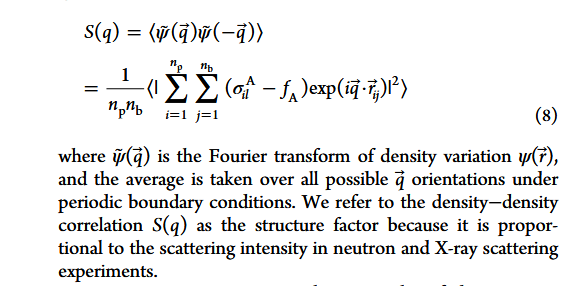

soft matter

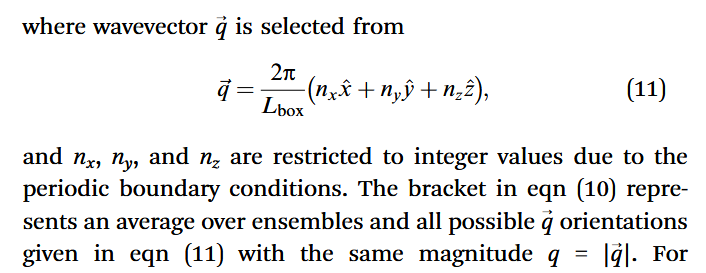

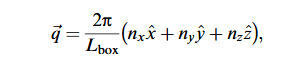

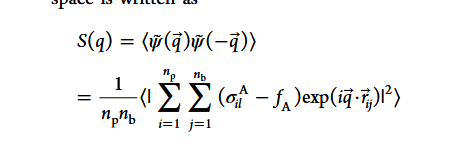

##### Helper functions

In [7]:
def gen_triples_vector(rnge):
    #to make sute itertools.combinations creates all permutations
    lst = []
    for i in range(rnge):
        lst += ([i]*3)
    return lst

In [8]:
def get_mag_vec_map(rnge, l_box = 20):
    comb_dict = {}
    #gen apropraiate vector
    trips = gen_triples_vector(rnge)
    for comb in itertools.combinations(trips, 3):
        comb = np.array(comb)
        comb_mag = np.linalg.norm(comb* (2*np.pi/l_box))
        # if comb_mag not in dictionary
        if comb_mag not in comb_dict:
            comb = comb * (2*np.pi/l_box)
            permutes = list(itertools.permutations(comb))
            for i in range(len(permutes)):
                #permutes[i] = list(permutes[i])
                permutes[i] = np.array(list(permutes[i]))
            permutes = np.unique(np.array(permutes), axis=0)
            comb_dict[comb_mag] = permutes
    return comb_dict

In [9]:
def structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, l_box=20):
    '''
    melt structure factor.  
    q_vectors is a list of vectors with same magnitude
    ''' 
    sum_avg = 0
    for q_vect in q_vectors:
        summ = 0
        A = df.Type - f_A
        B = 1j*np.dot(df.iloc[:,:3], q_vect)
        summ = (A*np.exp(B)).sum()            
        sum_avg += (np.absolute(summ)**2)/(np.shape(q_vectors)[0])#q_vectors.size
    return sum_avg * (1/(n_p*n_b))
    

##### Defining constants

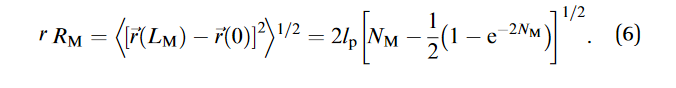

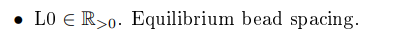

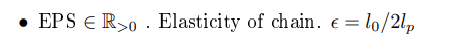

In [65]:
#constants
f_A = 0.5
n_p = 2000
n_b = 40
l_box = 20
l_pers = L0/(EPS*2)  #= 20.3
l_kuhn = 2*l_pers
N_M = 5*L0/(l_kuhn) 
R_M = 2*l_pers*(N_M - 0.5*(1-np.exp(-2*N_M)))**0.5 #unperturbed average end-to-end separation of a monomer- length of monomer

##### Calculating structure factor

rigid 0 lambda:

In [12]:
mag_vects_map = get_mag_vec_map(20, l_box = 20)
sorted_magnitudes = sorted(mag_vects_map.keys())
structure_fact_array = np.array([])
for mag in sorted_magnitudes:
    q_vectors = mag_vects_map[mag]
    sf_average = 0
    for df in chi_zero_list: #avging over ensembles
        sf = structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, l_box=20)
        sf_average += sf/(len(chi_zero_list)) 
    structure_fact_array = np.append(structure_fact_array, sf_average)

flexibile neg lambda:

In [14]:
mag_vects_map = get_mag_vec_map(20, l_box = 20)
sorted_magnitudes = sorted(mag_vects_map.keys())
structure_fact_array = np.array([])
structure_fact_array_chi_1p66 = np.array([])
for mag in sorted_magnitudes:
    q_vectors = mag_vects_map[mag]
#     for i,vec in enumerate(q_vectors): #put q vectors in terms of R_M
#         q_vectors[i] = vec*R_M
    #print(q_vectors)
    sf_average = 0
    for df in chi_zero_list: #avging over ensembles
        sf = structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, l_box=20)
        sf_average += sf/(len(chi_zero_list)) 
    structure_fact_array = np.append(structure_fact_array, sf_average)
    
    sf_average_chi_1p66 = 0
    for df in chi_1p66_list:
        sf = structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, l_box=20)
        sf_average_chi_1p66 += sf/(len(chi_1p66_list))
    structure_fact_array_chi_1p66 = np.append(structure_fact_array_chi_1p66, sf_average_chi_1p66)


In [15]:
structure_fact_array_chi_3p00 = np.array([])
for mag in sorted_magnitudes:
    q_vectors = mag_vects_map[mag]
    sf_average_chi_3p00 = 0
    for df in chi_3p00_list:
        sf = structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, l_box=20)
        sf_average_chi_3p00 += sf/(len(chi_3p00_list))
    structure_fact_array_chi_3p00 = np.append(structure_fact_array_chi_3p00, sf_average_chi_3p00)

In [16]:
structure_fact_array_chi_4p00 = np.array([])
for mag in sorted_magnitudes:
    q_vectors = mag_vects_map[mag]
    sf_average_chi_4p00 = 0
    for df in chi_4p00_list:
        sf = structure_factor_from_sim(df, q_vectors, n_p, n_b, f_A, l_box=20)
        sf_average_chi_4p00 += sf/(len(chi_4p00_list))
    structure_fact_array_chi_4p00 = np.append(structure_fact_array_chi_4p00, sf_average_chi_4p00)

In [18]:
# sort_magss = np.array(sorted_magnitudes)
# plt.loglog(sort_magss*R_M, structure_fact_array)
# plt.title("rigid melt structure factor chi=0")
# plt.xlabel("R_m*q")
# plt.ylabel("<>")
# plt.ylim((10**-1, 10**3))
# print("NEW ONE!")

In [74]:
(40*L0)/l_kuhn #num kuhn lengths per polymer

40.0

In [24]:
N_M * 8 #num kuhn lengths per polymer

40.0

### Theoretical Structure Factor:
##### from 2016 Macromolecules- ABmelt

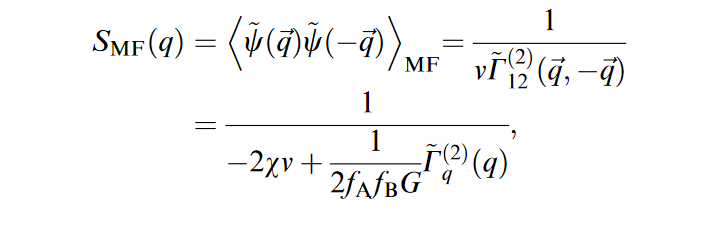

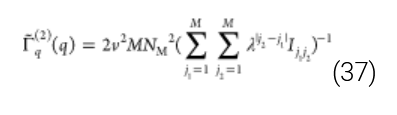

In [13]:
R_M_kuhn = np.sqrt(eng.r2wlc(N_M)) #end-to-end monomer seperation in kuhn lengths
mags_kuhn = (np.array(sorted_magnitudes)/R_M_kuhn)*R_M #how Q should be for this function
Q_matlab = matlab.double(mags_kuhn.tolist()) #function needs it in terms of R_M_kuhn

num_monomers = 8#*2000
sinv = eng.s2invwlc(matlab.double([num_monomers]), matlab.double([N_M]), matlab.double([f_A]), matlab.double([lambda_val]), Q_matlab)
sinv_arr = np.array([])
for elem in sinv:
    sinv_arr= np.append(sinv_arr, float(np.array(elem)))


##### from wlcstat (updated)- ABmelt

In [71]:
s2_aa, s2_ab, s2_bb = np.real(s2_wlc_randcopoly(mags_kuhn, float(N_M), num_monomers, f_A, lambda_val, alpha_max = 11))

In [72]:
gamma = (s2_aa + s2_bb + 2*s2_ab)/(s2_aa * s2_bb - s2_ab**2)
chival = 0
coef = 1/(2*f_A*(1-f_A)*5)
structurefactor = np.real(1/(-2*chival + coef*gamma))

###### Calc X_spinodal:

In [32]:
# X*v_m
[kval, sval, d2gam2] = eng.kmaxwlc(matlab.double([num_monomers]), matlab.double([N_M]), matlab.double([f_A]), matlab.double([lambda_val]), nargout=3)
chi_spin = .5 * sval
chi_comparison = (chi_spin/5) * 2 #chi = chi_s(no v_m) * 2
chi_comparison #0.333

#alt calc assuming its not x*v_m 
chi_comp = chi_spin * 2
chi_comp #1.66 is X_s * 2. Not in terms of vm

1.6676120981566591

In [33]:
chi_spin

0.8338060490783296

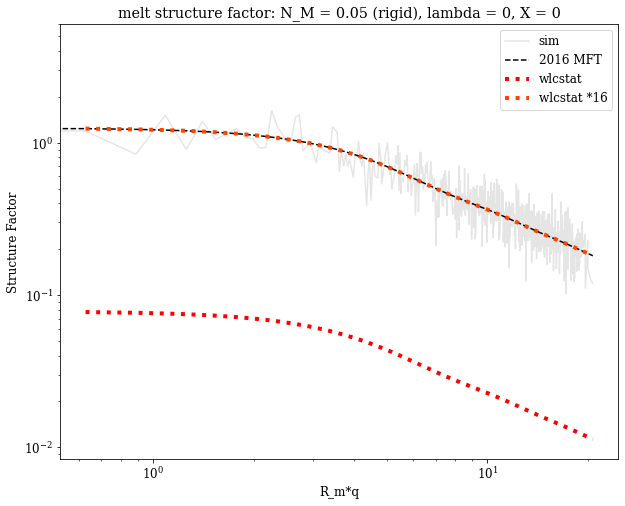

In [27]:

sort_magss = np.array(sorted_magnitudes)
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 12}
plt.rc('font', **font)
#simulation

plt.loglog(sort_magss*R_M, structure_fact_array, label = "sim", zorder=1,alpha = 0.1, color = "black") #*R_M

#2016 theory

plt.loglog(mags_kuhn*R_M_kuhn, (1/sinv_arr), label = "2016 MFT", color = "black", linestyle='dashed', zorder=4) #*R_M

#new wlcstat

#ensemble
plt.loglog(mags_kuhn*R_M_kuhn, structurefactor, label = "wlcstat", color = "red", linestyle='dotted',  linewidth=4, zorder=4) #*R_M
plt.loglog(mags_kuhn*R_M_kuhn, structurefactor*16, label = "wlcstat *16", alpha = 1, color = "orangered", linestyle='dotted',  linewidth=4, zorder=4)

#2017 paper
#plt.scatter([1, 5, 10], [1.02, 0.7, 0.381], label = "2017 soft matter", color = "tab:red", zorder=2) #rigid lam=0
#formatting

plt.title("melt structure factor: N_M = 0.05 (rigid), lambda = 0, X = 0")
plt.xlabel(r'R_m*q') #R_m*
plt.ylabel(r'Structure Factor')
# plt.ylim((2, 3.5))
# plt.xlim((2, 20))
# plt.tight_layout()
plt.legend()

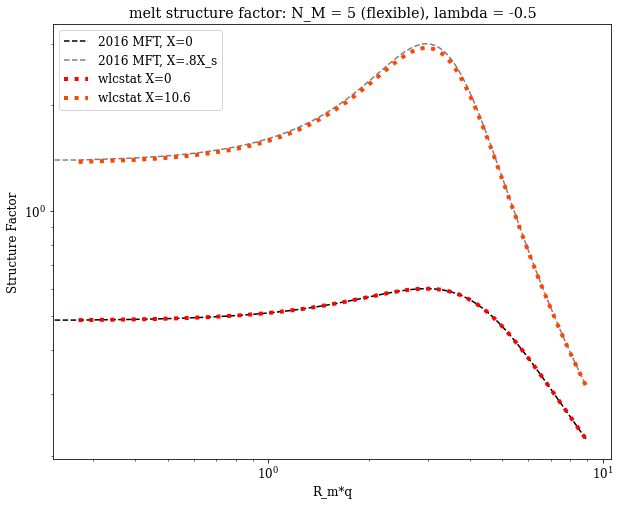

In [283]:
# sort_magss = np.array(sorted_magnitudes)
# plt.figure(figsize=(10,8))
# font = {'family' : 'serif',
#     'weight':'normal',
#     'size': 12}
# plt.rc('font', **font)

# #simulation
# # plt.loglog(sort_magss*R_M, structure_fact_array, label = "sim, X=0", zorder=1, color = "black") #*R_M
# # plt.loglog(sort_magss*R_M, structure_fact_array_chi_1p66, label = "sim, X=2X_s", zorder=2, color = "darkcyan")
# # plt.loglog(sort_magss*R_M, structure_fact_array_chi_3p00, label = "sim, X=4X_s", zorder=2, color = "darkslategray")
# # plt.loglog(sort_magss*R_M, structure_fact_array_chi_4p00, label = "sim, X=5X_s", zorder=2, color = "black")

# #2016
# plt.loglog(mags_kuhn*R_M_kuhn, (1/(sinv_arr)), label = "2016 MFT, X=0", color = "black", alpha = 1, linestyle='dashed', zorder=5)

# #plt.loglog(mags_kuhn*R_M_kuhn, (1/(-2*chi_spin*.8+sinv_arr)), label = "2016 MFT, X=0.8X_s", color = "khaki", linestyle='dashed', zorder=5)
# plt.loglog(mags_kuhn*R_M_kuhn, (1/(-2*chi_spin*.8+sinv_arr)), label = "2016 MFT, X=.8X_s", color = "gray", linestyle='dashed', zorder=5)

# #new wlcstat
# plt.loglog(mags_kuhn*R_M_kuhn, structurefactor*16, label = "wlcstat X=0", alpha = 1, color = "red", linestyle='dotted', linewidth=4, zorder=6)

# plt.loglog(mags_kuhn*R_M_kuhn, np.real(1/(-2*10.6 + coef*gamma))*16, label = "wlcstat X=10.6", color = "orangered", linewidth=4, linestyle='dotted', zorder=8) #*R_M



# #comparison

# #plt.scatter([1, 5, 10], [0.45, 0.5, 0.2], label = "2017 SM, X=0", color = "tab:red", zorder=3) #flex lam=-.5
# #plt.scatter([2], [11], label = "2017 SM, X=2*X_s", color = "darkred", zorder=4) #flex lam=-.5

# #formatting
# plt.title("melt structure factor: N_M = 5 (flexible), lambda = -0.5")
# plt.xlabel(r'R_m*q') #R_m*
# plt.ylabel(r'Structure Factor')
# # plt.ylim((2, 3.5))
# # plt.xlim((2, 20))
# # plt.tight_layout()
# plt.legend()



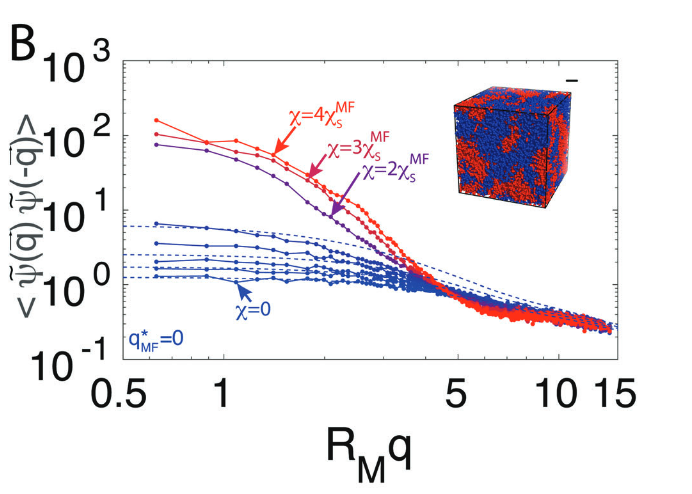

# A-A solution structure factor

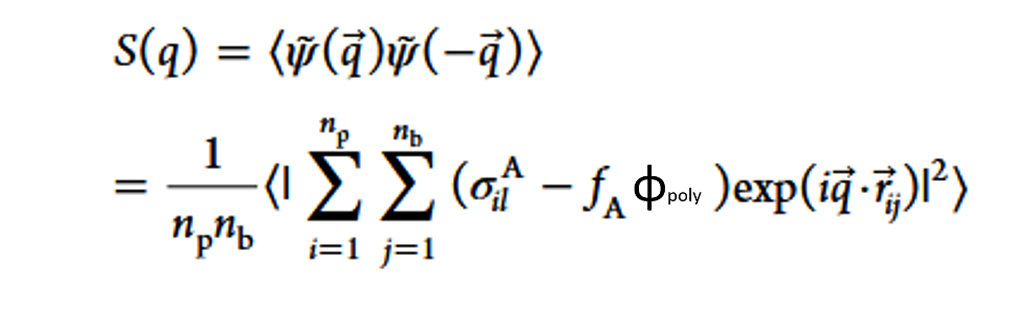

#### ORIGINAL ABsolution, 1000 poly:

In [543]:
#constants- 1000 polymers
f_A = 0.5
n_p = 1000
n_b = 40
l_box = 20
phi_poly=0.5
# inputs
#q=(2*np.pi*3)/l_box

#chi_zero_df
#R_m = 1#2.03 #unperturbed average end-to-end separation of a monomer

In [544]:
#EDIT PATHS
# chi_zero_1_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.13.21_ABmelt_fully_reproduced_shorter_range_96hrs_OLD/all_rs/r50v1"
# chi_zero_2_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_72hrs_OLD/all_rs/r39v1"
# chi_zero_3_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_160hrs_OLD/all_rs/r92v1"
# chi_zero_4_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_96hrs_OLD/all_rs/r49v1"
# chi_zero_5_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_120hrs_OLD/all_rs/r64v1"

chi_0_1000_orig_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/1000_polymers/original/r15v1"
chi_0p2_1000_orig_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/1000_polymers/original/r15v13"
chi_0p4_1000_orig_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/1000_polymers/original/r15v25"
chi_0p6_1000_orig_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/1000_polymers/original/r15v38"
chi_0p8_1000_orig_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/1000_polymers/original/r15v50"
chi_1_1000_orig_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/1000_polymers/original/r15v62"

name_list = ["X", "Y", "Z", "Type"] 
chi_0_1000_orig_df = pd.read_csv(chi_0_1000_orig_path, names = name_list, delim_whitespace=True)
chi_0p2_1000_orig_df = pd.read_csv(chi_0p2_1000_orig_path, names = name_list, delim_whitespace=True)
chi_0p4_1000_orig_df = pd.read_csv(chi_0p4_1000_orig_path, names = name_list, delim_whitespace=True)
chi_0p6_1000_orig_df = pd.read_csv(chi_0p6_1000_orig_path, names = name_list, delim_whitespace=True)
chi_0p8_1000_orig_df = pd.read_csv(chi_0p8_1000_orig_path, names = name_list, delim_whitespace=True)
chi_1_1000_orig_df = pd.read_csv(chi_1_1000_orig_path, names = name_list, delim_whitespace=True)
chi_1000_orig_list = [chi_0_1000_orig_df, chi_0p2_1000_orig_df, chi_0p4_1000_orig_df, chi_0p6_1000_orig_df, chi_0p8_1000_orig_df, chi_1_1000_orig_df]

In [545]:
chi_1000_chi_list = [0, 0.2, 0.4, 0.6, 0.8, 1]

In [546]:
#TO DO
#gaussian smoothing didnt work, so try averaging over ensembles DONE
#also, R_m could be wrong- may need to calculate? DONE
def structure_factor_from_sim_solution(df, q_vectors, n_p, n_b, f_A, phi_poly, l_box=20):
    '''
    melt structure factor.  
    q_vectors is a list of vectors with same magnitude
    '''
#     q_vectors= np.array([])    
#     q_mag_squared = ((q*l_box)/(2*np.pi))**2
    
#     if int(q_mag_squared) != q_mag_squared:
#         return None
#     else:
#         q_vectors = find_q_vects((q*l_box)/(2*np.pi))
 
    sum_avg = 0
    #print(np.shape(q_vectors)[0])
    for q_vect in q_vectors:
        #q_vect = q_vect * (2*np.pi)/l_box ALREADY DONE
        summ = 0
        #(A*e^B)
        A = df.Type - f_A*phi_poly
        B = 1j*np.dot(df.iloc[:,:3], q_vect)
        summ = (A*np.exp(B)).sum()            
        sum_avg += (np.absolute(summ)**2)/(np.shape(q_vectors)[0])#q_vectors.size
    return sum_avg * (1/(n_p*n_b))
    

In [547]:
mag_vects_map = get_mag_vec_map(20, l_box = 20)
sorted_magnitudes = sorted(mag_vects_map.keys())
    
structure_fact_array_list = []
for i in range(len(chi_1000_orig_list)):
    structure_fact_array_list.append(np.array([]))
#structure_fact_array_list = np.asarray(structure_fact_array_list)
for mag in sorted_magnitudes:
    q_vectors = mag_vects_map[mag]
#     for i,vec in enumerate(q_vectors): #put q vectors in terms of R_M
#         q_vectors[i] = vec*R_M
    #print(q_vectors)
    #sf_average = 0
    for i,df in enumerate(chi_1000_orig_list): #avging over ensembles CHANGE CHI ZERO LIST
        sf = structure_factor_from_sim_solution(df, q_vectors, n_p, n_b, f_A,phi_poly, l_box=20)
        structure_fact_array_list[i] = np.append(structure_fact_array_list[i], sf)
        #sf_average += sf/(len(chi_zero_list))
    #structure_fact_array = np.append(structure_fact_array, sf_average)


In [548]:
non_selective_last_chi = structure_fact_array_list[-1]

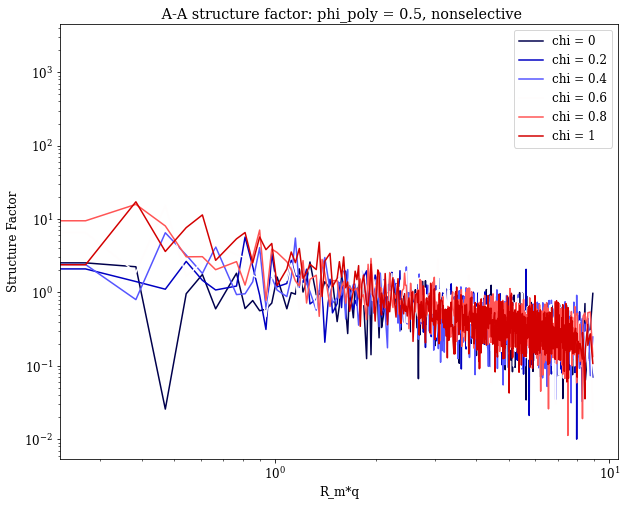

In [549]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 12}
plt.rc('font', **font)
COLOR = iter(cm.seismic(np.linspace(0, 1, len(chi_1000_chi_list)+1)))
sort_magss = np.array(sorted_magnitudes)
for i in range(len(chi_1000_chi_list)):
    color = next(COLOR)
    plt.loglog(sort_magss*R_M, structure_fact_array_list[i], label = "chi = " + str(chi_1000_chi_list[i]), color=color) #*R_M
plt.title(" A-A structure factor: phi_poly = 0.5, nonselective")#:1000 polymer soln unedited N_M = 0.05 (rigid), lambda = 0
plt.xlabel(r'R_m*q')
plt.ylabel(r'Structure Factor')
plt.legend()

#### EDITED ABsolution, 1000 poly:

define local volume fraction deviation = phi_A - f_A * phi_poly

In [550]:
#EDIT PATHS
# chi_zero_1_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.13.21_ABmelt_fully_reproduced_shorter_range_96hrs_OLD/all_rs/r50v1"
# chi_zero_2_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_72hrs_OLD/all_rs/r39v1"
# chi_zero_3_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_160hrs_OLD/all_rs/r92v1"
# chi_zero_4_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_96hrs_OLD/all_rs/r49v1"
# chi_zero_5_path = "C:\\users/tmhab/wlcsim_membrane/data/AB_melt_phase_diagram/5.8.21_ABmelt_fully_reproduced_120hrs_OLD/all_rs/r64v1"

chi_0_1000_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/1000_polymers/edited/r14v1"
chi_0p2_1000_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/1000_polymers/edited/r14v13"
chi_0p4_1000_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/1000_polymers/edited/r14v25"
chi_0p6_1000_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/1000_polymers/edited/r14v38"
chi_0p8_1000_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/1000_polymers/edited/r14v50"
chi_1_1000_path = "C:\\users/Thomas/wlcsim_membrane/data/struc_fac/1000_polymers/edited/r14v62"

name_list = ["X", "Y", "Z", "Type"] 
chi_0_1000_df = pd.read_csv(chi_0_1000_path, names = name_list, delim_whitespace=True)
chi_0p2_1000_df = pd.read_csv(chi_0p2_1000_path, names = name_list, delim_whitespace=True)
chi_0p4_1000_df = pd.read_csv(chi_0p4_1000_path, names = name_list, delim_whitespace=True)
chi_0p6_1000_df = pd.read_csv(chi_0p6_1000_path, names = name_list, delim_whitespace=True)
chi_0p8_1000_df = pd.read_csv(chi_0p8_1000_path, names = name_list, delim_whitespace=True)
chi_1_1000__df = pd.read_csv(chi_1_1000_path, names = name_list, delim_whitespace=True)
chi_1000_list = [chi_0_1000_df, chi_0p2_1000_df, chi_0p4_1000_df, chi_0p6_1000_df, chi_0p8_1000_df, chi_1_1000__df]

In [551]:
chi_1000_chi_list = [0, 0.2, 0.4, 0.6, 0.8, 1]

In [552]:
#constants- 1000 polymers
f_A = 0.5
n_p = 1000
n_b = 40
l_box = 20
phi_poly=0.5
# inputs
#q=(2*np.pi*3)/l_box

#chi_zero_df
#R_m = 1#2.03 #unperturbed average end-to-end separation of a monomer

In [553]:
mag_vects_map = get_mag_vec_map(20, l_box = 20)
sorted_magnitudes = sorted(mag_vects_map.keys())
    
structure_fact_array_list = []
for i in range(len(chi_1000_list)):
    structure_fact_array_list.append(np.array([]))
#structure_fact_array_list = np.asarray(structure_fact_array_list)
for mag in sorted_magnitudes:
    q_vectors = mag_vects_map[mag]
#     for i,vec in enumerate(q_vectors): #put q vectors in terms of R_M
#         q_vectors[i] = vec*R_M
    #print(q_vectors)
    #sf_average = 0
    for i,df in enumerate(chi_1000_list): #avging over ensembles CHANGE CHI ZERO LIST
        sf = structure_factor_from_sim_solution(df, q_vectors, n_p, n_b, f_A,phi_poly, l_box=20)
        structure_fact_array_list[i] = np.append(structure_fact_array_list[i], sf)
        #sf_average += sf/(len(chi_zero_list))
    #structure_fact_array = np.append(structure_fact_array, sf_average)


In [554]:
selective_last_chi = structure_fact_array_list[-1]

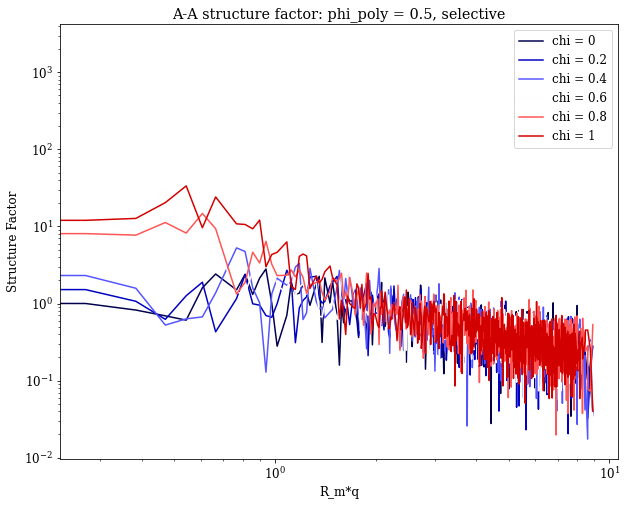

In [555]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 12}
plt.rc('font', **font)
sort_magss = np.array(sorted_magnitudes)
COLOR = iter(cm.seismic(np.linspace(0, 1, len(chi_1000_chi_list)+1)))
for i in range(len(chi_1000_chi_list)):
    color = next(COLOR)
    plt.loglog(sort_magss*R_M, structure_fact_array_list[i], label = "chi = " + str(chi_1000_chi_list[i]), color=color) #*R_M
plt.title("A-A structure factor: phi_poly = 0.5, selective")# N_M = 0.05 (rigid), lambda = 0
plt.xlabel(r'R_m*q')
plt.ylabel(r'Structure Factor')
plt.legend()

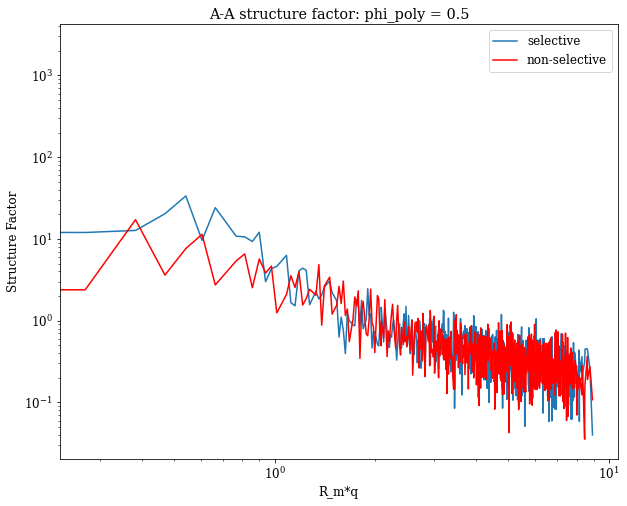

In [571]:
# last_chis = [selective_last_chi, nonselective_last_chi]
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 12}
plt.rc('font', **font)
plt.title("A-A structure factor: phi_poly = 0.5")# N_M = 0.05 (rigid), lambda = 0
plt.xlabel(r'R_m*q')
plt.ylabel(r'Structure Factor')

plt.loglog(sort_magss*R_M, selective_last_chi, label = "selective")
plt.loglog(sort_magss*R_M, non_selective_last_chi, label = "non-selective", color = "red")
plt.legend()

### Analytical Solution:

# TRASH

In [557]:
np.version.version

'1.19.2'

In [558]:
# Bead vector itself is the sigma values!
# def sigma(bead_type, comp_type):
#     if bead_type == comp_type:
#         return 1
#     elif bead_type != comp_type:
#         return 0

In [559]:
# #testing if [0,0,1] has same magnitude as [0, 0, -1] .if same mag, shouldnt matter. THEY DO HAVE SAME MAGNITUDE
# A_test = chi_zero_df.Type - 0.5
# B_pos = 1j*np.dot(chi_zero_df.iloc[:,:3], np.array([0, 0, 1]))
# B_neg =  1j*np.dot(chi_zero_df.iloc[:,:3], np.array([0, 0, -1]))

# summ_neg = (A_test*np.exp(B_neg)).sum()
# print(np.absolute(summ_neg))

# summ_pos = (A_test*np.exp(B_pos)).sum()
# print(np.absolute(summ_pos))

In [560]:
# def find_q_vects(q_magnitude):
#     '''
#     already multiplied by L_box and 2pi
#     '''
#     x_arr = np.arange(np.ceil(q_magnitude)+1)
#     y_arr = np.arange(np.ceil(q_magnitude)+1)
#     z_arr = np.arange(np.ceil(q_magnitude)+1)
#     q_init = np.array([])
#     q_failed_init = np.array([])
#     q_init = find_q_vects_rec(q_magnitude, q_init, q_failed_init, x_arr, y_arr, z_arr)
#     return q_init
    
# def find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem, z_arr_rem):
#     #print("before running, q_correct is:", q_correct)
#     if x_arr_rem.size == 0 and y_arr_rem.size == 0 and z_arr_rem.size == 0:
#         #stopping condition
#         return q_correct
#     else:
#         if x_arr_rem.size==0:
#             x = np.ceil(q_magnitude)
#         else:
#             x = x_arr_rem[0]
            
#         if y_arr_rem.size==0:
#             y = np.ceil(q_magnitude)
#         else:
#             y = y_arr_rem[0]
        
#         if z_arr_rem.size==0:
#             z = np.ceil(q_magnitude)
#         else:
#             z = z_arr_rem[0] 
        
#         pos_vect = np.array([x, y, z])
#         #print("-----------------")
#         #print("pos_vect is:", pos_vect)
#         #print("q_correct is:", q_correct)
#         #print("q_failed is:", q_failed)
#         #determine if any permutation of this vector have already been 
#         permutes = list(itertools.permutations(pos_vect))
#         for i in range(len(permutes)):
#             permutes[i] = list(permutes[i])
#         permutes = np.array(permutes)
        
#         for perm in permutes:
#             #print("one permutation is:", perm)
            
#             perm_in_q = False
#             perm_in_qf = False
#             for q in q_correct:
#                 if np.all([q, perm]):
#                     perm_in_q = True
#                     break
#             for q in q_failed:
#                 if np.all([q, perm]):       
                    
#             if perm_in_q:
#             #if perm in q_correct: #already found a permutation works
#                 #print("ALREADY DONE")
#                 #next recursive step NECESSARY BUT WHY
#                 #q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem, z_arr_rem[1:])
#                 #q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem[1:], z_arr_rem)
#                 #q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem[1:], y_arr_rem, z_arr_rem)

#                 return q_correct
#              elif perm in q_failed:
# #                 print(perm in q_failed)
# #                 #already found a permutation failed
# #                 print("already failed!!!")
# #                 return q_correct
#         #print("mag is:", np.linalg.norm(pos_vect))
#         if np.linalg.norm(pos_vect) == q_magnitude:
#             #print("is good!")
#             if q_correct.size == 0:
#                 q_correct = np.array([pos_vect])
#             else:
#                 q_correct = np.append(q_correct, [pos_vect], axis=0)
            
#             #next recursive step
#             q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem, z_arr_rem[1:])
#             q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem[1:], z_arr_rem)
#             q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem[1:], y_arr_rem, z_arr_rem)
            
#             return q_correct

#         else:
#             if q_failed.size == 0:
#                 q_failed = np.array([pos_vect])
#             else:
#                 q_failed = np.append(q_failed, [pos_vect], axis=0)
            

#             #next recursive step
#             q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem, z_arr_rem[1:])
#             q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem, y_arr_rem[1:], z_arr_rem)
#             q_correct = find_q_vects_rec(q_magnitude, q_correct, q_failed, x_arr_rem[1:], y_arr_rem, z_arr_rem)
            
#             return q_correct
        
#     return q_correct



# TEST 2016 FUNC

In [561]:
# N_M_testing = 0.1
# R_M_kuhn_testing = np.sqrt(eng.r2wlc(matlab.double([N_M_testing]))) #end-to-end monomer seperation in kuhn lengths
# Q_matlab = matlab.double((np.array(sorted_magnitudes)/R_M_kuhn_testing).tolist()) #function needs it in terms of R_M_kuhn

# num_monomers = 100 #no impact
# lambda_val = -.75
# sinv_test = eng.s2invwlc(matlab.double([num_monomers]), matlab.double([N_M_testing]), matlab.double([f_A]), matlab.double([lambda_val]), Q_matlab)
# sinv_arr_test = np.array([])
# for elem in sinv_test:
#     sinv_arr_test = np.append(sinv_arr_test, float(np.array(elem)))


In [562]:
# plt.loglog((np.array(sorted_magnitudes)/R_M_kuhn_testing)*R_M_kuhn_testing, (1/sinv_arr_test), label = "2016 macromolecules", color = "tab:orange")

In [563]:
# plt.loglog(sort_magss, (1/sinv_arr_test), label = "2016 macromolecules", color = "tab:orange")

In [564]:
#np.array(sorted_magnitudes)/R_M_kuhn_testing

In [565]:
# # calc from 2016 Macromolecules abmelt. lambda = 0
# Q0=1#; %minimumwavevector
# QF=10#; %maximumwavevector
# NQ=100#; %numberofwavevectors
# Q=np.transpose(np.logspace(np.log10(Q0),np.log10(QF),NQ))/R_M_kuhn_testing#RM;
# Q_matlab_2 = matlab.double(Q.tolist())
# sinv_test_2 = eng.s2invwlc(matlab.double([num_monomers]), matlab.double([N_M_testing]), matlab.double([f_A]), matlab.double([lambda_val]), Q_matlab_2)
# sinv_arr_test_2 = np.array([])
# for elem in sinv_test_2:
#     sinv_arr_test_2 = np.append(sinv_arr_test_2, float(np.array(elem)))


In [566]:
# plt.loglog((sort_magss/R_M_kuhn_testing)*(R_M_kuhn_testing), (1/sinv_arr_test), label = "2016 macromolecules", color = "tab:orange")

# END OF TEST
conc: could multiply struc fact by 100 or mulpilt N_M by 100

NEW ONE!


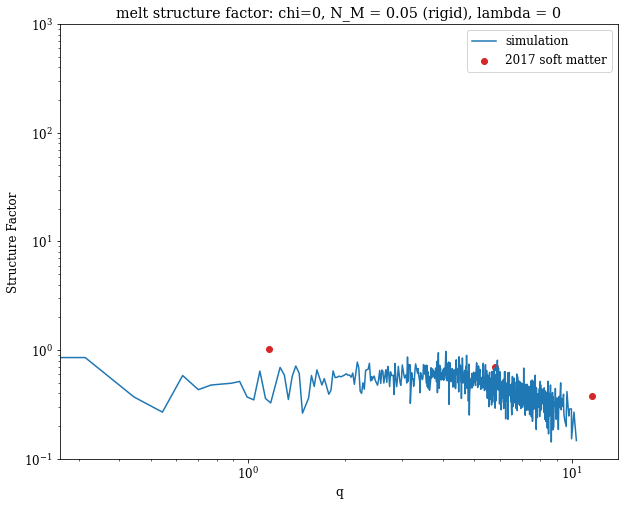

In [567]:
plt.figure(figsize=(10,8))
font = {'family' : 'serif',
    'weight':'normal',
    'size': 12}
plt.rc('font', **font)
sort_magss = np.array(sorted_magnitudes)
plt.loglog(sort_magss, structure_fact_array, label = "simulation") #*R_M
plt.title("melt structure factor: chi=0, N_M = 0.05 (rigid), lambda = 0")
plt.xlabel("R_m*q")
plt.ylabel("<>")
plt.ylim((10**-1, 10**3))
print("NEW ONE!")

#changed from * lungth_kuhn to * R_m
#plt.loglog(sort_magss, np.real(structure_factor), label = "OLD mft wlcstat", color = "tab:green")#not considering A or B interac

#2016
#plt.loglog(mags_kuhn*R_M_kuhn, (1/sinv_arr), label = "2016 macromolecules", color = "tab:orange") #*(2*l_pers) *R_M, *100

#plt.loglog(sort_magss, (1/sinv_arr)*100, alpha = 0.5, label = "2016 * 100", color = "tab:orange") #*(2*l_pers) *R_M, *100

plt.scatter([1/R_M, 5/R_M, 10/R_M], [1.02, 0.7, 0.38], label = "2017 soft matter", color = "tab:red")

#plt.loglog(sort_magss, (1/sinv_arr_test), label = "N_M * 100", color = "tab:green")

plt.xlabel(r'q') #R_m*
plt.ylabel(r'Structure Factor')
# plt.ylim((2, 3.5))
# plt.xlim((2, 20))
# plt.tight_layout()
plt.legend()

In [ ]:
# # EXAMPLE- works
# Q0=1e-2#; %minimumwavevector
# QF=1e4#; %maximumwavevector
# NQ=201#; %numberofwavevector
# R_M_2016 = np.sqrt(eng.r2wlc(0.1))
# Q=np.transpose(np.logspace(np.log10(Q0),np.log10(QF),NQ))#/R_M
# Q_matlab = matlab.double(Q.tolist())
# num_monomers = 100
# lambda_val = -0.75
# N_M_2016 = 0.1
# sinv = eng.s2invwlc(matlab.double([num_monomers]), matlab.double([N_M_2016]), matlab.double([f_A]), matlab.double([lambda_val]), Q_matlab)
# sinv_arr = np.array([])
# for elem in sinv:
#     sinv_arr= np.append(sinv_arr, float(np.array(elem)))


## Testing wlcstat ensemble structure factor

In [202]:
ind_k_val = 2
k_val = Q[ind_k_val]
alpha_max=25
lam_max=alpha_max
poles = eval_poles(k_val, 0, dimensions=3, alpha_max=alpha_max)
residues = eval_residues(k_val, 0, poles, True, dimensions=3, lam_max=alpha_max, alpha_max=alpha_max, k_val_cutoff=10 ** -3)
ind_length = 0
lam = -0.5
num_mono = 8
fa = 0.5

length_mono_kuhn = np.array([5]) #1.1 works, 1.2 doesnt

In [203]:
k_val_vector = Q
s2_aa = np.zeros((len(k_val_vector), len(length_mono_kuhn)), dtype=type(1+1j))
s2_ab = np.zeros((len(k_val_vector), len(length_mono_kuhn)), dtype=type(1+1j))
s2_bb = np.zeros((len(k_val_vector), len(length_mono_kuhn)), dtype=type(1+1j))


In [208]:
poles

array([-5.45159506e-03+0.j, -1.99672442e+00+0.j, -5.99922300e+00+0.j,
       -1.19996373e+01+0.j, -1.99997880e+01+0.j, -2.99998605e+01+0.j,
       -4.19999011e+01+0.j, -5.59999261e+01+0.j, -7.19999427e+01+0.j,
       -8.99999543e+01+0.j, -1.09999963e+02+0.j, -1.31999969e+02+0.j,
       -1.55999974e+02+0.j, -1.81999977e+02+0.j, -2.09999980e+02+0.j,
       -2.39999983e+02+0.j, -2.71999985e+02+0.j, -3.05999987e+02+0.j,
       -3.41999988e+02+0.j, -3.79999989e+02+0.j, -4.19999990e+02+0.j,
       -4.61999991e+02+0.j, -5.05999992e+02+0.j, -5.51999993e+02+0.j,
       -5.99999993e+02+0.j, -6.49999994e+02+0.j])

In [209]:
length_mono_kuhn[ind_length]

5

In [207]:
np.cosh(poles[11] * length_mono_kuhn[ind_length])

(2.1540736595756356e+286-0j)

In [212]:
np.cosh(-649*5)

<ipython-input-212-8bc1627605cd>:1: RuntimeWarning: overflow encountered in cosh
  np.cosh(-649*5)


inf

In [213]:
            for alpha in range(0, alpha_max):
                #print("ALPHA IS ", alpha)
                z0 = np.exp(poles[alpha] * length_mono_kuhn[ind_length])
                z1 = z0 * lam
                valeq = (2 * num_mono * (z0 / poles[alpha] ** 2 - 1 / poles[alpha] ** 2 -
                                         length_mono_kuhn[ind_length] / poles[alpha]))
                #print("valq:", valeq)
                valne1 = (4 / poles[alpha] ** 2 * z0 *
                          (z0 ** num_mono - num_mono * z0 + num_mono - 1) /
                          (1 - z0) ** 2 * (np.cosh(poles[alpha] * length_mono_kuhn[ind_length]) - 1))
                #print("valne1:", valne1)
                valne2 = (4 / poles[alpha] ** 2 * z1 *
                          (z1 ** num_mono - num_mono * z1 + num_mono - 1) /
                          (1 - z1) ** 2 * (np.cosh(poles[alpha] * length_mono_kuhn[ind_length]) - 1))
                #print("valne2:", valne2)

                s2_aa[ind_k_val, ind_length] += (residues[alpha] * (fa * valeq +
                                                                    fa ** 2 * valne1 + fa * (1 - fa) * valne2))
                s2_ab[ind_k_val, ind_length] += (residues[alpha] * (fa * (1 - fa) * valne1 -
                                                                    fa * (1 - fa) * valne2))
                s2_bb[ind_k_val, ind_length] += (residues[alpha] * ((1 - fa) * valeq +
                                                                    (1 - fa) ** 2 * valne1 + fa * (1 - fa) * valne2))

<ipython-input-213-5d53c6c9f0d6>:10: RuntimeWarning: overflow encountered in cosh
  (1 - z0) ** 2 * (np.cosh(poles[alpha] * length_mono_kuhn[ind_length]) - 1))
<ipython-input-213-5d53c6c9f0d6>:14: RuntimeWarning: overflow encountered in cosh
  (1 - z1) ** 2 * (np.cosh(poles[alpha] * length_mono_kuhn[ind_length]) - 1))


conclusion- need to restrict aplha max as num kuhn per monomer (flexiblity) increases- at N_m = 5, alpha_max =11

testing!! ^^